In [3]:
import torch
import matplotlib.pyplot as plt

device = torch.device("cpu" if torch.cuda.is_available() else "cpu")
torch.set_default_dtype(torch.float32)

In [11]:
# PARAMS
HBAR        = 1.0
MASS        = 1.0
PBC         = True
N_PARTICLES = 2
N_POINTS    = 10

# Two particles

### Exact Diagonalization

The one body part (kinetic and potential terms) of the hamiltonian in the position basis reads:

$$H = \mathbb{I}\otimes \dots \otimes K_i\otimes \mathbb{I}\otimes ...\otimes \mathbb{I}+\mathbb{I}\otimes \dots \otimes V_i\otimes \mathbb{I}\otimes ...\otimes \mathbb{I}$$

Where $K_i \equiv -\frac{\hbar^2}{2m}\nabla_i^2,\quad V_i \equiv V(x_i)$ and $i$ is the index of the particle.

How to construct the hamiltonian: Given a base (in this case distretized positions) $\ket{x_1 x_2...x_p}$ with $p$ particles

$$\hat H = \sum_{i,j,...}\sum_{ i', j', ...}\bra{x_i x_j...}\hat{H}\ket{x_{i'} x_{j'}...}\ket{x_i x_j...}\bra{x_{i'} x_{j'}...}$$

Where $\hat{H} = \sum_{i=1}^P T_i+V_i + \sum_{i<j}U(x_i-y_j)$

With two particles, the matrix elements $\bra{x_i y_j}\hat{H}\ket{x_i y_j}$ are:

$$\bra{x_i y_j}\hat{H}\ket{x_i y_j} = \bra{x_i}T+V\ket{x_j} + \braket{y}$$

$$\hat{H} = \sum_{i_1=1}^N \cdots \sum_{i_P=1}^N \sum_{j_1=1}^N \cdots \sum_{j_P=1}^N
\langle x_{i_1} x_{i_2} \dots x_{i_P} | \hat{H} | x_{j_1} x_{j_2} \dots x_{j_P} \rangle
\, | x_{i_1} x_{i_2} \dots x_{i_P} \rangle \langle x_{j_1} x_{j_2} \dots x_{j_P} |$$


$$\hat{H} = \sum_{i_1\cdots i_P=1}^N \sum_{j_1\cdots j_P=1}^N
\langle x_{i_1} x_{i_2} \dots x_{i_P} | \hat{H} | x_{j_1} x_{j_2} \dots x_{j_P} \rangle
\, | x_{i_1} x_{i_2} \dots x_{i_P} \rangle \langle x_{j_1} x_{j_2} \dots x_{j_P} |$$

For 2 particles we have:

$$\hat{H} = \sum_{i_1 i_2 = 1}^2\sum_{j_1 j_2 = 1}^2\langle x_{i_1} x_{i_2} | \hat{H} | x_{j_1} x_{j_2} \rangle
\, | x_{i_1} x_{i_2}\rangle \langle x_{j_1} x_{j_2} |$$

Where

$$\langle x_{i_1} x_{i_2} | \hat{H} | x_{j_1} x_{j_2} \rangle = \langle x_{i_1} x_{i_2} | T_1+V_1+T_2+V_2+\sum_{i<j}U_{ij} | x_{j_1} x_{j_2} \rangle = $$

$$= \langle x_{i_1} | T_1+V_1\ket{x_{j_1}}\langle{x_{i_2}}|{x_{j_2}}\rangle+\langle x_{i_2} | T_2+V_2\ket{x_{j_2}}\langle{x_{i_1}}|{x_{j_1}}\rangle+\sum_{i<j} \langle x_{i_1} x_{i_2} |U_{ij}| x_{j_1} x_{j_2} \rangle$$

Using that in position space, the potentials are diagonal: $\langle y| V | x\rangle = V(x)\delta_{xy}$

$$= \langle x_{i_1} | T_1+V_1\ket{x_{j_1}}\delta_{{x_{i_2}}{x_{j_2}}}+\langle x_{i_2} | T_2+V_2\ket{x_{j_2}}\delta_{{x_{i_1}}x_{j_1}}+\sum_{i<j}U(x_{j_1} x_{j_2})$$

In [12]:
def identity(NGrid):
    """Create the identity operator for N particles."""
    return torch.eye(NGrid, device=device)

II = identity(N_POINTS)

In [13]:
def single_particle_potential(x,V0,K1):
    return V0*torch.sin(K1*x).pow(2)

In [7]:
def hamiltonian_matrix(N_POINTS, GRID_SPACING, PBC, potential_parameters, x):
    kin_coeff = -HBAR**2 / (2 * MASS * GRID_SPACING**2)
    kin_main_diag = -2*torch.ones(N_POINTS, device=device)  # Main diagonal for kinetic energy
    kin_off_diags = 1*torch.ones(N_POINTS-1, device=device)  # Off-diagonal elements for kinetic energy
    # kin_matrix = torch.zeros((N_POINTS, N_POINTS))
    kin_matrix = torch.diag(kin_main_diag).to(device)
    kin_matrix += torch.diag(kin_off_diags, diagonal=1)
    kin_matrix += torch.diag(kin_off_diags, diagonal=-1)
    if PBC:
        kin_matrix[0, -1] = 1
        kin_matrix[-1, 0] = 1
    pot_matrix = torch.zeros((N_POINTS, N_POINTS), device=device)
    for i in range(N_POINTS):
        pot_matrix[i, i] = single_particle_potential(x[i],**potential_parameters)
        # TO TRY HARMONIC POTENTIAL COMMENT OUT ABOVE LINE AND UNCOMMENT BELOW
        # pot_matrix[i, i] = 0.5*MASS* x[i]**2  # Harmonic potential
    return kin_coeff * kin_matrix + pot_matrix

tensor([-3.0000, -2.9597, -2.9195, -2.8792, -2.8389, -2.7987, -2.7584, -2.7181,
        -2.6779, -2.6376, -2.5973, -2.5570, -2.5168, -2.4765, -2.4362, -2.3960,
        -2.3557, -2.3154, -2.2752, -2.2349, -2.1946, -2.1544, -2.1141, -2.0738,
        -2.0336, -1.9933, -1.9530, -1.9128, -1.8725, -1.8322, -1.7919, -1.7517,
        -1.7114, -1.6711, -1.6309, -1.5906, -1.5503, -1.5101, -1.4698, -1.4295,
        -1.3893, -1.3490, -1.3087, -1.2685, -1.2282, -1.1879, -1.1477, -1.1074,
        -1.0671, -1.0268, -0.9866, -0.9463, -0.9060, -0.8658, -0.8255, -0.7852,
        -0.7450, -0.7047, -0.6644, -0.6242, -0.5839, -0.5436, -0.5034, -0.4631,
        -0.4228, -0.3826, -0.3423, -0.3020, -0.2617, -0.2215, -0.1812, -0.1409,
        -0.1007, -0.0604, -0.0201,  0.0201,  0.0604,  0.1007,  0.1409,  0.1812,
         0.2215,  0.2617,  0.3020,  0.3423,  0.3826,  0.4228,  0.4631,  0.5034,
         0.5436,  0.5839,  0.6242,  0.6644,  0.7047,  0.7450,  0.7852,  0.8255,
         0.8658,  0.9060,  0.9463,  0.98

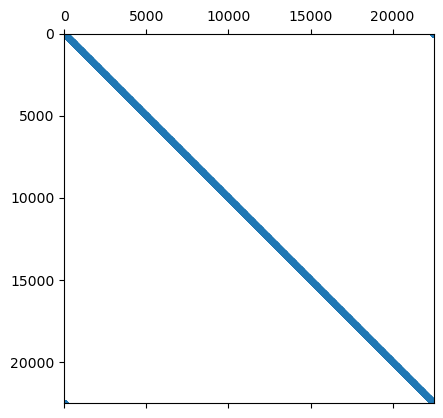

In [6]:
pos = torch.linspace(-3, 3, N_POINTS, device=device)
print(pos)
X_i,X_j = torch.meshgrid(pos,pos, indexing='ij')

one_body_hami = hamiltonian_matrix(
    N_POINTS=N_POINTS,
    GRID_SPACING=pos[1] - pos[0],
    PBC=PBC,
    potential_parameters={
        'V0': 1.0,
        'K1': torch.pi
    },
    x=pos
)

print(one_body_hami)
print(torch.kron(one_body_hami,II))
print(torch.kron(II,one_body_hami))

full_onebody_hami = torch.kron(II, one_body_hami)+ torch.kron(one_body_hami, II)
print(full_onebody_hami)
# Plotting the Hamiltonian matrix
plt.spy(full_onebody_hami.cpu(), markersize=1)

In [7]:
def interaction_potential(x1, x2, g):
    """Define the interaction potential between two particles."""
    return g * torch.exp(-((x1 - x2) ** 2)/(2 * 0.5 ** 2))

In [8]:
two_body_matrix = interaction_potential(X_i,X_j,1.0)
print(two_body_matrix)

tensor([[1.0000e+00, 9.9676e-01, 9.8711e-01,  ..., 3.6695e-31, 1.4096e-31,
         5.3802e-32],
        [9.9676e-01, 1.0000e+00, 9.9676e-01,  ..., 9.4904e-31, 3.6695e-31,
         1.4096e-31],
        [9.8711e-01, 9.9676e-01, 1.0000e+00,  ..., 2.4386e-30, 9.4904e-31,
         3.6695e-31],
        ...,
        [3.6695e-31, 9.4904e-31, 2.4386e-30,  ..., 1.0000e+00, 9.9676e-01,
         9.8711e-01],
        [1.4096e-31, 3.6695e-31, 9.4904e-31,  ..., 9.9676e-01, 1.0000e+00,
         9.9676e-01],
        [5.3802e-32, 1.4096e-31, 3.6695e-31,  ..., 9.8711e-01, 9.9676e-01,
         1.0000e+00]])


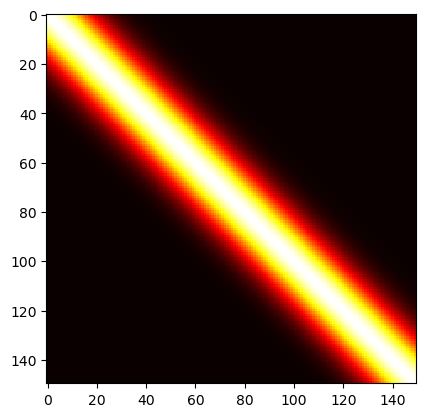

In [9]:
plt.imshow(two_body_matrix.cpu(), cmap='hot', interpolation='nearest')

tensor([[1234.3910, -308.3477,    0.0000,  ...,    0.0000,    0.0000,
            0.0000],
        [-308.3477, 1234.4037, -308.3477,  ...,    0.0000,    0.0000,
            0.0000],
        [   0.0000, -308.3477, 1234.4407,  ...,    0.0000,    0.0000,
            0.0000],
        ...,
        [   0.0000,    0.0000,    0.0000,  ..., 1234.4407, -308.3477,
            0.0000],
        [   0.0000,    0.0000,    0.0000,  ..., -308.3477, 1234.4037,
         -308.3477],
        [   0.0000,    0.0000,    0.0000,  ...,    0.0000, -308.3477,
         1234.3910]])


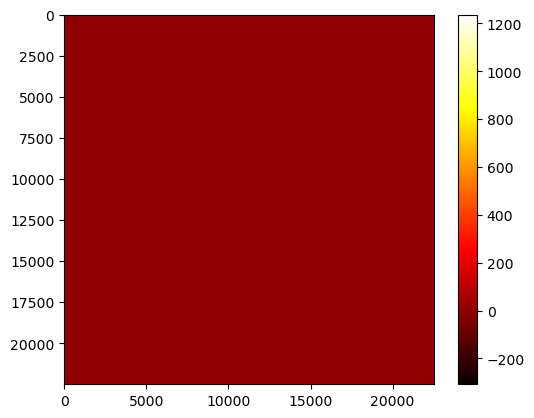

: 

In [ ]:
def total_hami(one_body, potential):
    potential_flattened = potential.flatten()
    total_matrix = one_body + torch.diag(potential_flattened)
    return total_matrix
total_matrix = total_hami(full_onebody_hami, two_body_matrix)

plt.imshow((total_matrix).cpu(), cmap='hot')
plt.colorbar()

# define the labels:

labels = []

for i in range(N_POINTS):
    for j in range(N_POINTS):
        labels.append(f"|{i},{j}>")

# Set the labels for the axes
# plt.xticks(ticks=range(len(labels)), labels=labels, rotation=90)
# plt.yticks(ticks=range(len(labels)), labels=labels)
# plt.show();

# only show some labels
# label_spacing = 499
# plt.xticks(ticks=range(0, len(labels), label_spacing), labels=labels[::label_spacing], rotation=90)
# plt.yticks(ticks=range(0, len(labels), label_spacing), labels=labels[::label_spacing])
# plt.xlim(0, 5)
# plt.ylim(0, 5)
;

# print(total_matrix)

In [ ]:
evals, evecs = torch.linalg.eigh(total_matrix)
print("Eigenvalues:", evals[:10])  # Print the first 10 eigenvalues
# plot gs 
gs_eigenvector = evecs[:, 0].reshape(N_POINTS, N_POINTS)
plt.imshow(gs_eigenvector.cpu().real, cmap='hot')
plt.colorbar()

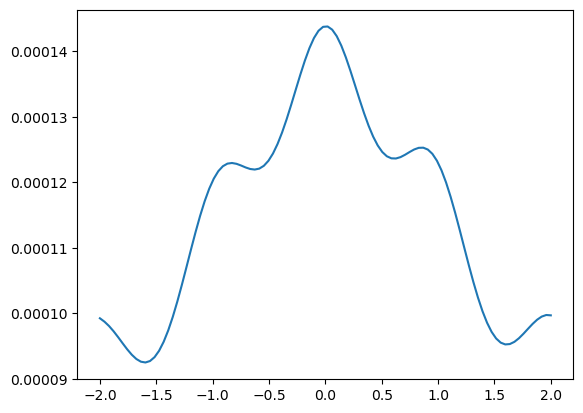

In [ ]:
# plot state with particle 2 at 0
gs_2nd_particle = gs_eigenvector[:, 0]  # Take the first column for particle 2 at position 0
plt.plot(pos.cpu().numpy(), gs_2nd_particle.cpu().real**2, label='Particle 2 at 0')
# plt.ylim(0, torch.max(gs_2nd_particle**2).item() + 0.1)
# plt.plot(pos.cpu().numpy(), torch.sin(torch.pi*pos).pow(2).cpu().numpy(), label='Potential')

In [24]:
def get_idx(first_parti, second_parti):
    """Get the index for the state |first_parti, second_parti>."""
    return first_parti * N_POINTS + second_parti

# Example usage of get_idx
i = 0
j = 1
idx = get_idx(i, j)
print(f"Index for state |{i},{j}>: {idx}")

print(f"two_body pot at idx |{i},{j}>: {two_body_matrix[i,j]}")
print(f"flattened two_body pot at idx |{i},{j}>: {two_body_matrix.flatten()[idx]}")

Index for state |0,1>: 1
two_body pot at idx |0,1>: 0.9967403411865234
flattened two_body pot at idx |0,1>: 0.9967403411865234


In [37]:
test_reshaping = torch.tensor([[1, 2, 3], [4, 5, 6]])
flattened = test_reshaping.flatten()
print("Flattened tensor:", flattened)
reconstructed  = flattened.reshape(2,3)
print("Reconstructed tensor:", reconstructed)

Flattened tensor: tensor([1, 2, 3, 4, 5, 6])
Reconstructed tensor: tensor([[1, 2, 3],
        [4, 5, 6]])


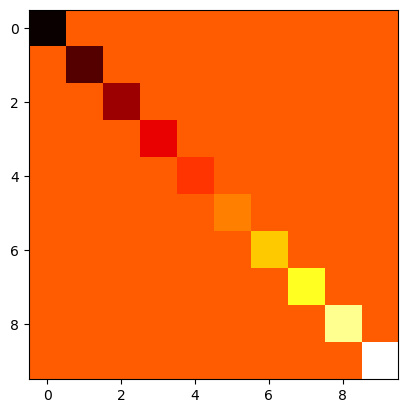

In [18]:
N_points = 2
II = identity(N_points)

def constant_pot(x, V0=1.0):
    """Define a constant potential."""
    return V0 * torch.ones_like(x)* x

def one_body_potential_matrix(x):
    """Create the one-body potential matrix."""

    return torch.diag(constant_pot(x))

x = torch.linspace(-3, 3, N_POINTS, device=device)
one_body_potential = one_body_potential_matrix(x)
plt.imshow(one_body_potential.cpu(), cmap='hot')

position 0,0 in full potential: -6.0
position 0,0 in potential   : -3.0


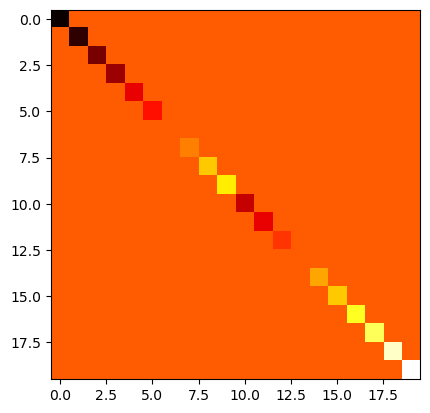

In [19]:
full_potential = torch.kron(one_body_potential, II) + torch.kron(II, one_body_potential)
plt.imshow(full_potential.cpu(), cmap='hot')

print(f"position 0,0 in full potential: {full_potential[0,0]}")
print(f"position 0,0 in potential   : {one_body_potential[0,0]}")

## HOW TO COMPUTE IDX

If i have a $N$ states $P$ particle QMB state, i can label the state such that:

$$\ket{\psi} = \ket{n_1,n_2,...,n_p}$$

where each $n_i\in\{0,...,N-1\}$. Then, the flattened idx is computed as:

$$idx = \sum_{p=1}^P n_p N^{P-p}$$

Example:

Given the state $\ket{0,2,1}$ with $N=3$, the idx is:

$$idx = 0\cdot 3^2 + 2 \cdot 3^1 + 1 = 7$$

If we do it manually:

- (0,0,0): 0
- (0,0,1): 1
- (0,0,2): 2
- (0,1,0): 3
- (0,1,1): 4
- (0,1,2): 5
- (0,2,0): 6
- **(0,2,1): 7**
- (0,2,2): 8

$\vdots$

In [53]:
from collections.abc import Sequence
import numpy as np


def compute_idx(input, N_states, N_particles):
    """Compute the index for a given input state."""
    if isinstance(input, int):
        return input
    if np.any(np.array(input) >= N_states):
        raise ValueError("Input indices must be less than N_states.")
    elif isinstance(input, Sequence) and len(input) == N_particles:
        idx = 0
        for i in range(1,N_particles+1):
            idx += input[i-1] * (N_states ** (N_particles - i))
        return idx
    else:
        raise ValueError("Input must be an integer or an iterable of particle indices.")
    
def compute_idxs(input, N_states, N_particles):

    array = []
    for particle in range(N_particles):
        array.append(np.floor_divide(input,N_states**(N_particles - particle -1)))
        input = input - array[-1] * N_states**(N_particles - particle - 1)
    return np.array(array, dtype=int)


In [56]:
test_idx = compute_idx([2,1,1], 3, 3)
print(test_idx)
print(compute_idxs(test_idx, 3, 3))

22
[2 1 1]


In [48]:
i = 4
N_states = 3
input = [0, 2, 1]
print(bool(np.any(i< N_states for i in input)))

True
